In [7]:
import os
import sys
project_root = os.path.abspath("/blue/vabfmc/data/working/d.uriartediaz/francokrepel/project-root")
os.chdir(project_root)  # Change directory to project_root
print("Current working directory:", os.getcwd())
import torch
from torchvision import transforms
from src.models.simclr_model import SimCLRModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# test_graph_creation.py

import pandas as pd
import os
import numpy as np
import networkx as nx
from torch_geometric.utils import from_networkx

# Parameters
slide_id_to_test = 'slide-2022-02-09T12-26-27-R5-S1'  # Replace with your slide_id

# Load features
df = pd.read_csv('data/features/patch_features.csv')

# Convert feature columns to numeric types (if applicable)
feature_cols = [str(i) for i in range(512) if str(i) in df.columns]
if feature_cols:
    df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
    # Handle missing values
    if df[feature_cols].isnull().values.any():
        print("Warning: NaNs detected in feature columns. Filling NaNs with zero.")
        df[feature_cols] = df[feature_cols].fillna(0)
else:
    print("No feature columns found. Proceeding without features.")


Current working directory: /blue/vabfmc/data/working/d.uriartediaz/francokrepel/project-root


In [8]:

# Load slide labels
metadata = pd.read_csv('data/BCC_labels.csv')
labels_dict = dict(zip(metadata['slide_id'], metadata['label']))
label_mapping = {'Clear': 0, 'Present': 1}
df['label'] = df['slide_id'].map(labels_dict).map(label_mapping)

# Filter the DataFrame for the specific slide
slide_df = df[df['slide_id'] == slide_id_to_test]

if slide_df.empty:
    print(f"No data found for slide_id: {slide_id_to_test}")
else:
    # Extract features and coordinates for this slide
    if feature_cols:
        features_array = slide_df[feature_cols].values.astype(np.float32)
    else:
        features_array = None  # If no features are available

    coords_array = slide_df[['x_coord', 'y_coord']].values.astype(int)

    # Use coordinates directly as grid positions
    grid_positions = [tuple(pos) for pos in coords_array]

    # Create mapping from grid positions to node indices
    grid_to_node = {pos: idx for idx, pos in enumerate(grid_positions)}

    # Create a graph
    G = nx.Graph()

    # Add nodes
    node_ids = slide_df.index.tolist()
    for i, node_id in enumerate(node_ids):
        if features_array is not None:
            G.add_node(node_id, feature=features_array[i], coords=coords_array[i])
        else:
            G.add_node(node_id, coords=coords_array[i])

    # Add edges to immediate neighbors
    for i, node_id1 in enumerate(node_ids):
        pos = grid_positions[i]
        neighbors = [
            (pos[0] - 1, pos[1]),     # Left
            (pos[0] + 1, pos[1]),     # Right
            (pos[0], pos[1] - 1),     # Above
            (pos[0], pos[1] + 1),     # Below
            (pos[0] - 1, pos[1] - 1), # Top-left
            (pos[0] - 1, pos[1] + 1), # Bottom-left
            (pos[0] + 1, pos[1] - 1), # Top-right
            (pos[0] + 1, pos[1] + 1)  # Bottom-right
        ]
        for neighbor_pos in neighbors:
            if neighbor_pos in grid_to_node:
                node_id2 = node_ids[grid_to_node[neighbor_pos]]
                G.add_edge(node_id1, node_id2)

    # Output the number of nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    print(f"Graph for slide_id: {slide_id_to_test}")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")


Graph for slide_id: slide-2022-02-09T12-26-27-R5-S1
Number of nodes: 3921
Number of edges: 13810


/scratch/local/49326512/ipykernel_2650350/2153445332.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['label'] = df['slide_id'].map(labels_dict).map(label_mapping)


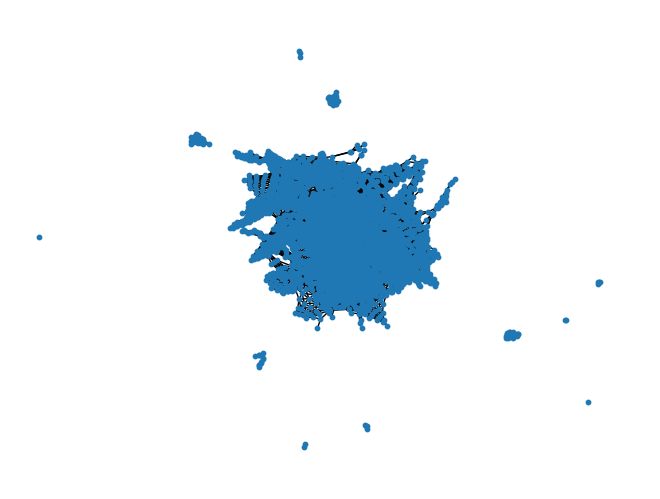

In [9]:
import matplotlib.pyplot as plt
nx.draw(G, node_size=10)
plt.show()